# A/B Testing Analysis: Website Background Color Impact 

## 1. Project Overview

**Background**

This project analyzes the effectiveness of website background color changes on user engagement and conversion rates for a UK-based retail website. The company is considering switching from their current white background (default) to a black background to potentially improve user experience and business outcomes.

**Business Problem**

The retail company wants to answer the critical question: **"Do people spend more time and engage better with a website when the background color is black versus white?"** This decision could significantly impact user engagement, conversion rates, and ultimately revenue.

**A/B Testing Scenario**

- **Control Group (A)**: Users experiencing the current white background
- **Treatment Group (B)**: Users experiencing the proposed black background
- **Primary Objective**: Determine if the black background leads to statistically significant improvements in key metrics

**Dataset Description**

The analysis uses a synthetic dataset containing user interaction data from visitors across the United Kingdom, including:
- **User ID**: Unique identifier for each user
- **Group**: Control (A) vs Treatment (B) assignment
- **Page Views**: Number of pages viewed per session
- **Time Spent**: Total session duration in seconds
- **Conversion**: Whether user completed desired action (Yes/No)
- **Device**: Device type used (Mobile, Desktop, Tablet)
- **Location**: User's location within the UK

**Data Source**: 
- **Dataset**: A/B Testing Practice Dataset
- **Source**: [Kaggle](https://www.kaggle.com/datasets/adarsh0806/ab-testing-practice)
- **Sample Size**: 5,000 users
- **Type**: Synthetic dataset created for A/B testing practice and demonstration

**Key Metrics to Evaluate**

1. **Primary Metric**: Conversion Rate (business impact)
2. **Secondary Metrics**: 
- Time Spent on site (engagement)
- Page Views per session (user interest)
3. **Segmentation Analysis**: Performance across different devices and locations

**Expected Outcomes**

This analysis will provide data-driven recommendations on whether to implement the black background across the website, backed by statistical evidence and business impact assessment.

## 2. Setup

### 2.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, shapiro, levene, mannwhitneyu
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore')

### 2.2 Load data

In [2]:
#Load the dataset
df = pd.read_csv('ab_testing.csv')

# First few rows
df.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


## 3. Data Exploration

### 3.1 Dataset Overview

In [3]:
# Dataset shape and basic info
print(f"Shape of the dataset : {df.shape}")
print(f"Number of Rows : {df.shape[0]}")
print(f"Number of columns : {df.shape[1]}")

Shape of the dataset : (5000, 7)
Number of Rows : 5000
Number of columns : 7


In [4]:
# Column information and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   object
 2   Page Views  5000 non-null   int64 
 3   Time Spent  5000 non-null   int64 
 4   Conversion  5000 non-null   object
 5   Device      5000 non-null   object
 6   Location    5000 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.6+ KB


In [5]:
# Descriptive statistics for numerical columns
df.describe()

,User ID,Page Views,Time Spent
count,5000.000000,5000.000000,5000.000000
mean,14925.159000,7.537600,242.512600
std,2869.153773,4.022465,118.254153
min,10001.000000,1.000000,40.000000
25%,12456.250000,4.000000,137.000000
50%,14858.500000,8.000000,243.000000
75%,17379.750000,11.000000,346.000000
max,19995.000000,14.000000,449.000000


In [6]:
# Check unique values in categorical columns
categorical_cols = ['Group', 'Conversion', 'Device', 'Location']
for col in categorical_cols:
    print(f"\n{col}:")
    print(f"Unique values : {df[col].unique()}")
    print(f"Value counts : {df[col].value_counts()}")


Group:
Unique values : ['B' 'A']
Value counts : Group
A    2519
B    2481
Name: count, dtype: int64

Conversion:
Unique values : ['No' 'Yes']
Value counts : Conversion
No     4515
Yes     485
Name: count, dtype: int64

Device:
Unique values : ['Mobile' 'Desktop']
Value counts : Device
Desktop    2538
Mobile     2462
Name: count, dtype: int64

Location:
Unique values : ['Northern Ireland' 'Scotland' 'Wales' 'England']
Value counts : Location
Scotland            1281
England             1246
Northern Ireland    1242
Wales               1231
Name: count, dtype: int64


### 3.2 Data Quality Assessment

In [7]:
# Check for missing values
df.isnull().sum()

User ID       0
Group         0
Page Views    0
Time Spent    0
Conversion    0
Device        0
Location      0
dtype: int64

In [8]:
# Check for duplicate user id's
print(f"Duplicate User ID's : {df['User ID'].duplicated().sum()}")

Duplicate User ID's : 0


In [9]:
# Check data ranges for any anomalies
print(f"Page Views : Min - {df['Page Views'].min()}, Max - {df['Page Views'].max()}")
print(f"Time spent : Min - {df['Time Spent'].min()}, Max - {df['Time Spent'].max()}")

Page Views : Min - 1, Max - 14
Time spent : Min - 40, Max - 449


In [10]:
# Using IQR method for outlier detection
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

In [11]:
# Check outliers in Page Views
pv_outliers, pv_lower, pv_upper = detect_outliers_iqr(df, 'Page Views')
print(f"Page Views outliers: {len(pv_outliers)} ({len(pv_outliers)/len(df)*100:.1f}%)")
print(f"Expected range: {pv_lower:.1f} to {pv_upper:.1f}")

Page Views outliers: 0 (0.0%)
Expected range: -6.5 to 21.5


In [12]:
# Check outliers in Time Spent
ts_outliers, ts_lower, ts_upper = detect_outliers_iqr(df, 'Time Spent')
print(f"Time Spent outliers: {len(ts_outliers)} ({len(ts_outliers)/len(df)*100:.1f}%)")
print(f"Expected range: {ts_lower:.1f} to {ts_upper:.1f} seconds")

Time Spent outliers: 0 (0.0%)
Expected range: -176.5 to 659.5 seconds


### 3.3 Group Distribution Analysis

In [13]:
# Overall group distribution
print(df['Group'].value_counts())
print('\n')
print(df['Group'].value_counts(normalize=True))

Group
A    2519
B    2481
Name: count, dtype: int64


Group
A    0.5038
B    0.4962
Name: proportion, dtype: float64


In [14]:
# Check if groups are balanced across Device types
print("Group Distribution by Device:")
device_group = pd.crosstab(df['Device'], df['Group'], normalize='index')
device_group

Group Distribution by Device:


Group,A,B
Device,,
Desktop,0.490150,0.509850
Mobile,0.517872,0.482128


In [15]:
# Check if groups are balanced across Locations
print("Group Distribution by Location:")
location_group = pd.crosstab(df['Location'], df['Group'], normalize='index')
location_group

Group Distribution by Location:


Group,A,B
Location,,
England,0.486356,0.513644
Northern Ireland,0.494364,0.505636
Scotland,0.523029,0.476971
Wales,0.510967,0.489033


### 3.4 Target Variable Distribution Analysis

In [16]:
# 1. Distribution analysis using describe()
target_vars = ['Page Views', 'Time Spent']
for var in target_vars:
    print(f"\n{var}:")
    print(df[var].describe())


Page Views:
count    5000.000000
mean        7.537600
std         4.022465
min         1.000000
25%         4.000000
50%         8.000000
75%        11.000000
max        14.000000
Name: Page Views, dtype: float64

Time Spent:
count    5000.000000
mean      242.512600
std       118.254153
min        40.000000
25%       137.000000
50%       243.000000
75%       346.000000
max       449.000000
Name: Time Spent, dtype: float64


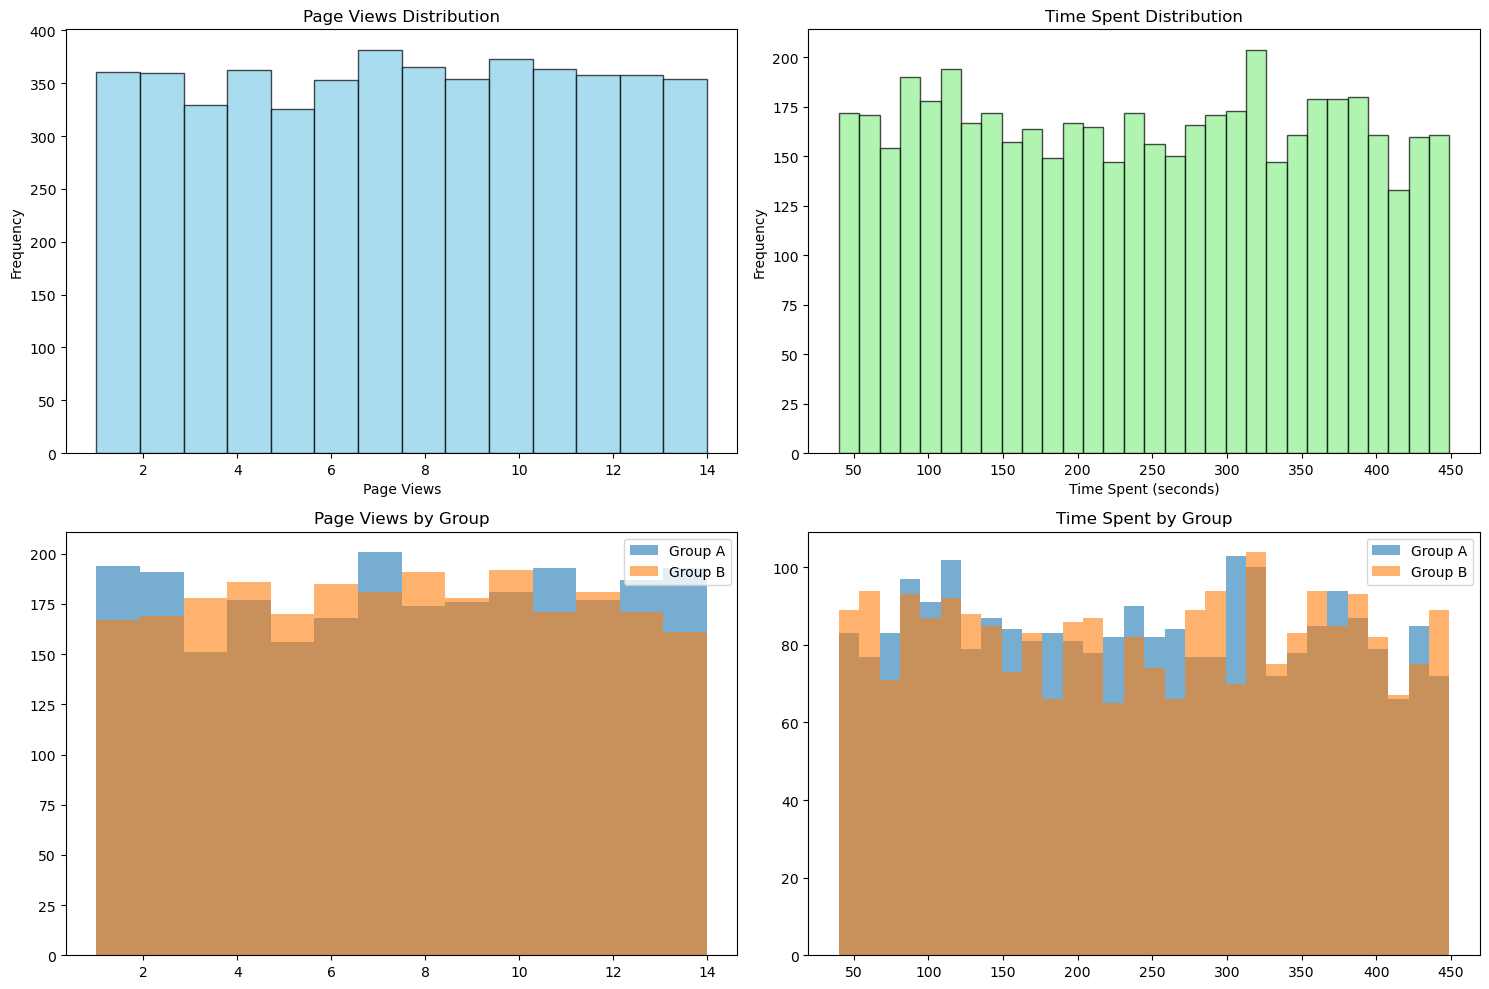

In [17]:
# 2. Histograms showing actual distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Page Views histogram
axes[0,0].hist(df['Page Views'], bins=14, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Page Views Distribution')
axes[0,0].set_xlabel('Page Views')
axes[0,0].set_ylabel('Frequency')

# Time Spent histogram
axes[0,1].hist(df['Time Spent'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Time Spent Distribution')
axes[0,1].set_xlabel('Time Spent (seconds)')
axes[0,1].set_ylabel('Frequency')

# Page Views by Group
axes[1,0].hist(df[df['Group']=='A']['Page Views'], bins=14, alpha=0.6, label='Group A')
axes[1,0].hist(df[df['Group']=='B']['Page Views'], bins=14, alpha=0.6, label='Group B')
axes[1,0].set_title('Page Views by Group')
axes[1,0].legend()

# Time Spent by Group
axes[1,1].hist(df[df['Group']=='A']['Time Spent'], bins=30, alpha=0.6, label='Group A')
axes[1,1].hist(df[df['Group']=='B']['Time Spent'], bins=30, alpha=0.6, label='Group B')
axes[1,1].set_title('Time Spent by Group')
axes[1,1].legend()

plt.tight_layout()
plt.show()

Interpretation

- Both page views and time spent are roughly symmetric, unimodal, and very similar between groups
- The overlapping distributions in both bottom charts suggest that user engagement metrics (Page Views and Time Spent) appear very similar between the white and black backgrounds. This visual pattern indicates that any differences in overall performance might come from other behaviors rather than basic engagement patterns.

In [18]:
# 3. Shape interpretation
print(f"Page Views skewness: {df['Page Views'].skew():.3f}")
print(f"Time Spent skewness: {df['Time Spent'].skew():.3f}")

Page Views skewness: -0.024
Time Spent skewness: 0.005


### 3.5 Segment Analysis

In [19]:
# Create conversion rate analysis
conv_data = []
pv_data = []
ts_data = []

for group in ['A', 'B']:
    # Device analysis for this group
    for device in df['Device'].unique():
        subset = df[(df['Group'] == group) & (df['Device'] == device)]
        conv_data.append([group, 'Device', device, (subset['Conversion'] == 'Yes').mean()])
        pv_data.append([group, 'Device', device, subset['Page Views'].mean()])
        ts_data.append([group, 'Device', device, subset['Time Spent'].mean()])
    
    # Location analysis for this group  
    for location in df['Location'].unique():
        subset = df[(df['Group'] == group) & (df['Location'] == location)]
        conv_data.append([group, 'Location', location, (subset['Conversion'] == 'Yes').mean()])
        pv_data.append([group, 'Location', location, subset['Page Views'].mean()])
        ts_data.append([group, 'Location', location, subset['Time Spent'].mean()])

# Create DataFrames with hierarchical structure
conv_df = pd.DataFrame(conv_data, columns=['Group', 'Type', 'Segment', 'Conversion_Rate'])
pv_df = pd.DataFrame(pv_data, columns=['Group', 'Type', 'Segment', 'Page_Views']) 
ts_df = pd.DataFrame(ts_data, columns=['Group', 'Type', 'Segment', 'Time_Spent'])

# Merge all metrics
segment_analysis = conv_df.merge(pv_df, on=['Group', 'Type', 'Segment']).merge(ts_df, on=['Group', 'Type', 'Segment'])

# Set hierarchical index
segment_analysis = segment_analysis.set_index(['Group', 'Type', 'Segment'])
segment_analysis

Conversion_Rate  Page_Views  Time_Spent
Group Type     Segment                                                  
A     Device   Mobile                   0.049412    7.642353  240.369412
               Desktop                  0.058682    7.519293  243.131029
      Location Northern Ireland         0.050489    7.648208  238.661238
               Scotland                 0.049254    7.632836  237.970149
               Wales                    0.047695    7.453100  248.759936
               England                  0.069307    7.590759  241.712871
B     Device   Mobile                   0.142376    7.440607  243.375737
               Desktop                  0.139104    7.540958  243.238022
      Location Northern Ireland         0.114650    7.326433  247.558917
               Scotland                 0.150573    7.530278  230.235679
               Wales                    0.151163    7.480066  245.161130
               England                  0.146875    7.632812  249.857812

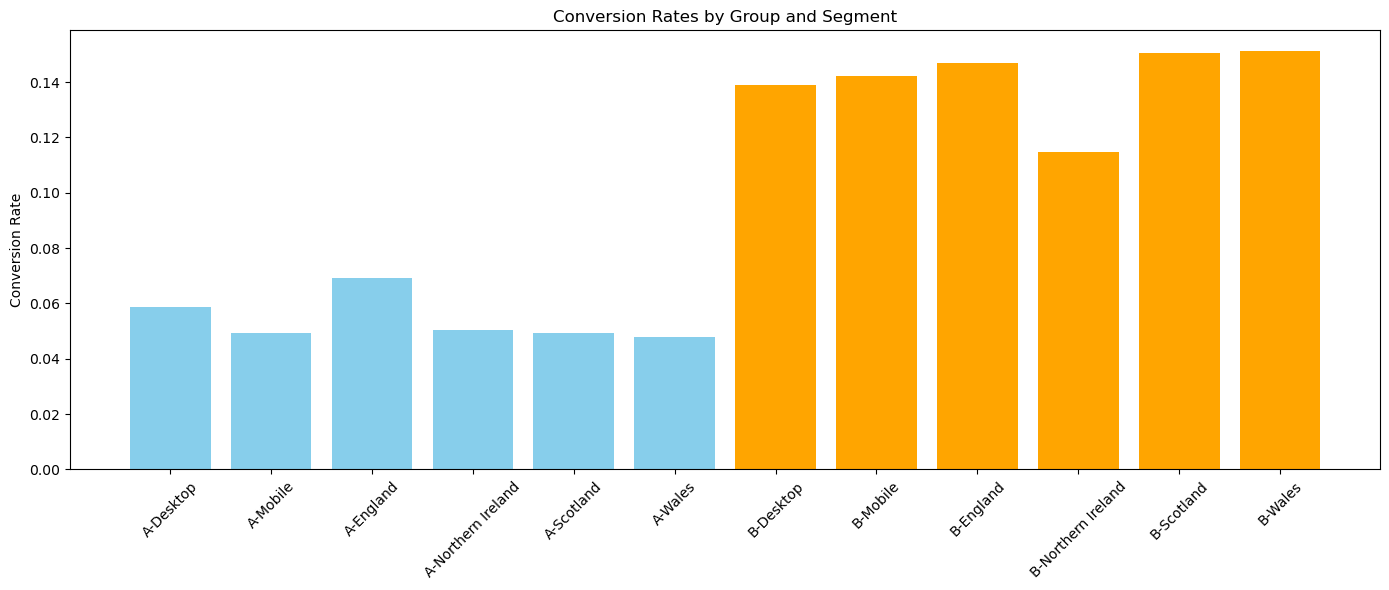

In [20]:
# 1. Grouped Bar Chart for Conversion Rates
plt.figure(figsize=(14, 6))

# Reset index and sort properly
plot_data = segment_analysis.reset_index()
plot_data = plot_data.sort_values(['Group', 'Type', 'Segment'])

# Create the bar chart with proper data order
x_pos = range(len(plot_data))
colors = ['skyblue' if group == 'A' else 'orange' for group in plot_data['Group']]

plt.bar(x_pos, plot_data['Conversion_Rate'], color=colors)
plt.title('Conversion Rates by Group and Segment')
plt.ylabel('Conversion Rate')
plt.xticks(x_pos, [f"{row['Group']}-{row['Segment']}" for _, row in plot_data.iterrows()], rotation=45)
plt.tight_layout()
plt.show()

Interpretation

- Light blue bars (Group A - White background): All show low conversion rates between 4.7%-6.9%
- Orange bars (Group B - Black background): All show high conversion rates between 11.5%-15.1%
- Group B outperforms Group A across every single segment

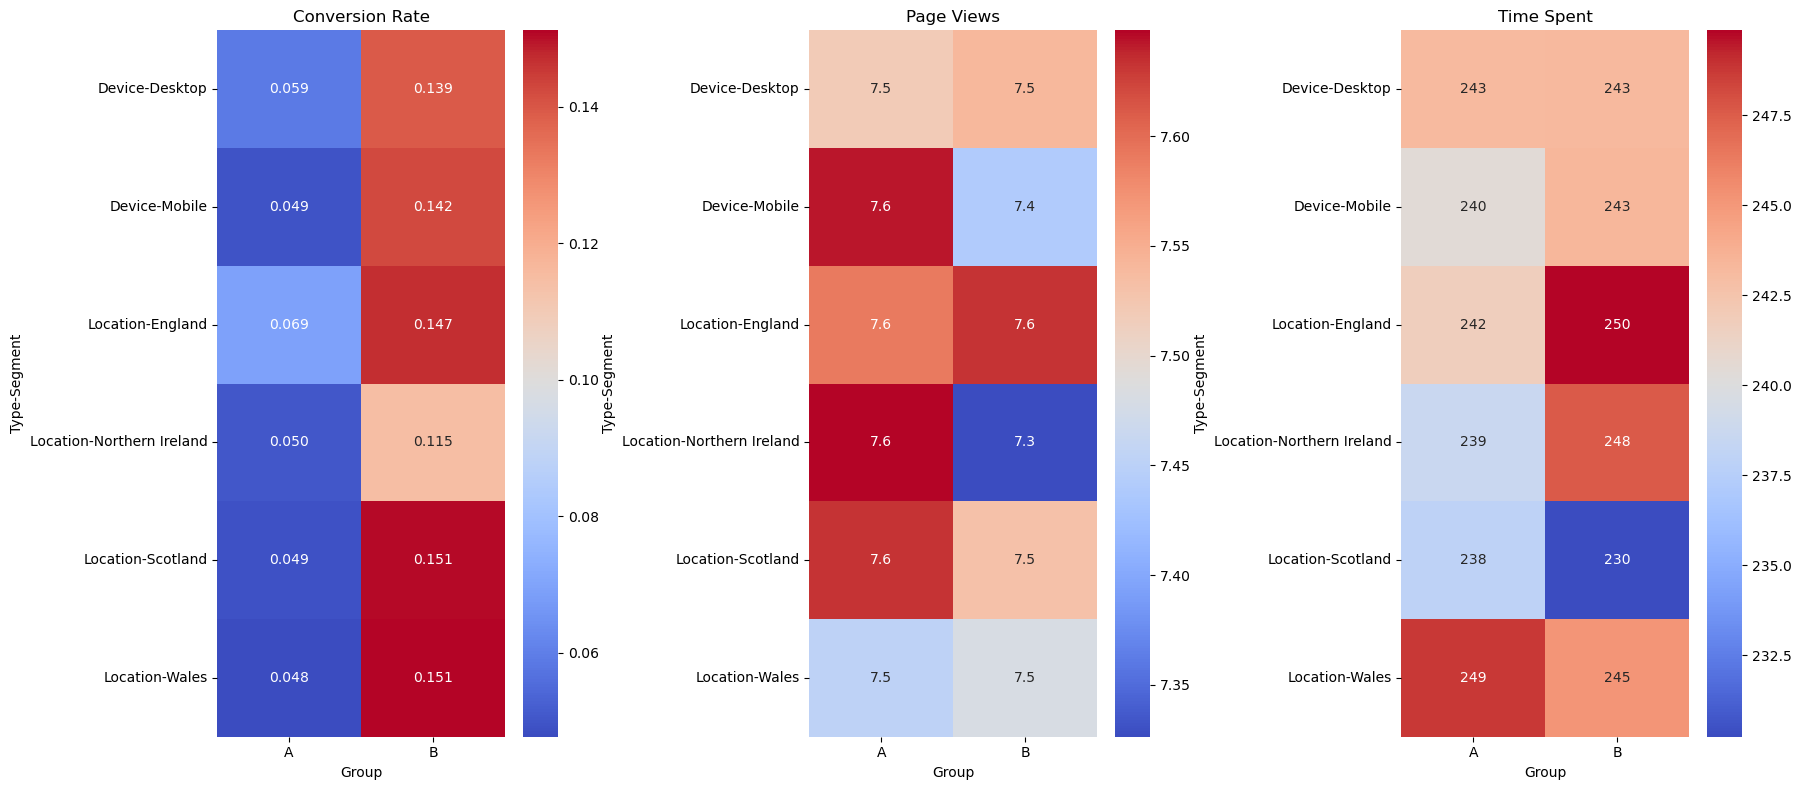

In [21]:
# 2. Heatmap visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Prepare data for heatmap
heatmap_data = plot_data.pivot_table(values=['Conversion_Rate', 'Page_Views', 'Time_Spent'],
                                     index=['Type', 'Segment'], 
                                     columns='Group')

# Conversion Rate heatmap
conv_heatmap = heatmap_data['Conversion_Rate']
sns.heatmap(conv_heatmap, annot=True, fmt='.3f', ax=axes[0], cmap='coolwarm')
axes[0].set_title('Conversion Rate')

# Page Views heatmap  
pv_heatmap = heatmap_data['Page_Views']
sns.heatmap(pv_heatmap, annot=True, fmt='.1f', ax=axes[1], cmap='coolwarm')
axes[1].set_title('Page Views')

# Time Spent heatmap
ts_heatmap = heatmap_data['Time_Spent'] 
sns.heatmap(ts_heatmap, annot=True, fmt='.0f', ax=axes[2], cmap='coolwarm')
axes[2].set_title('Time Spent')

plt.tight_layout()
plt.show()

Interpretation

The heatmaps show strong contrast in conversion rates between groups (blue vs red patterns) while page views and time spent show minimal systematic differences, indicating the background color effect is isolated to conversion behavior.

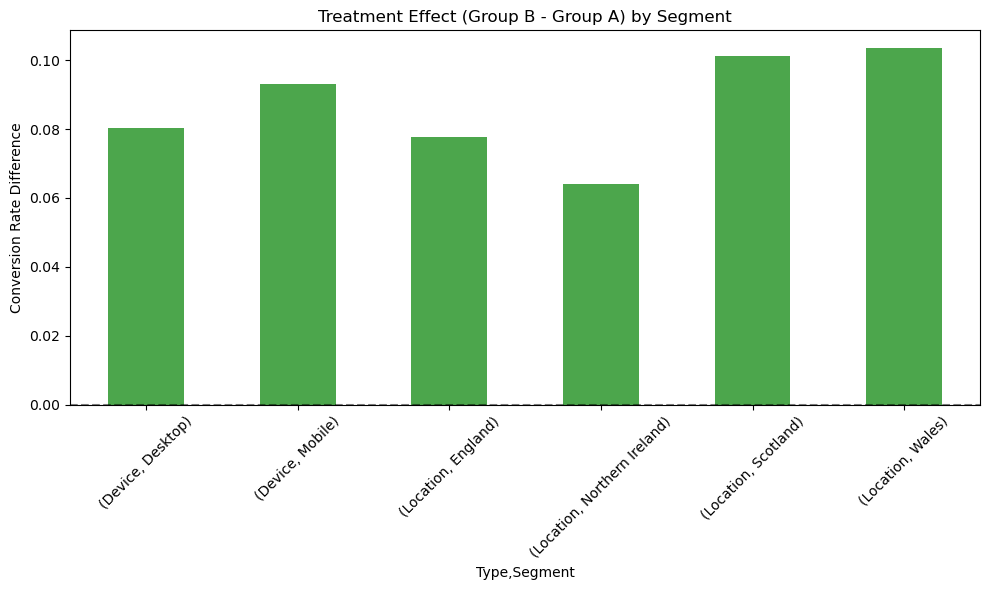

In [22]:
# 3. Treatment Effect Visualization
treatment_effects = heatmap_data.loc[:, ('Conversion_Rate', 'B')] - heatmap_data.loc[:, ('Conversion_Rate', 'A')]

plt.figure(figsize=(10, 6))
treatment_effects.plot(kind='bar', color='green', alpha=0.7)
plt.title('Treatment Effect (Group B - Group A) by Segment')
plt.ylabel('Conversion Rate Difference')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Interpretation

This chart shows the difference in conversion rates (Group B minus Group A) for each segment. The black background consistently improves conversion rates by 6-10 percentage points across all segments, with no segment showing neutral or negative effects, confirming the treatment works universally.

## 4. Statistical Analysis

### 4.1 Descriptive Statistics by Group

In [23]:
# Page Views by group
df.groupby('Group')['Page Views'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
A,2519.0,7.581580,4.080066,1.0,4.0,8.0,11.0,14.0
B,2481.0,7.492946,3.963448,1.0,4.0,8.0,11.0,14.0


In [24]:
# Time Spent by group  
df.groupby('Group')['Time Spent'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
A,2519.0,241.733227,117.340026,40.0,137.5,241.0,343.0,449.0
B,2481.0,243.303910,119.193552,40.0,136.0,244.0,348.0,449.0


In [25]:
# Conversion rates
conversion_rates = df.groupby('Group')['Conversion'].apply(lambda x: (x == 'Yes').mean())
print(conversion_rates)

Group
A    0.053990
B    0.140669
Name: Conversion, dtype: float64


### 4.2 Hypothesis Testing Setup

Define hypotheses for each metric

1. CONVERSION RATE:
- **H0 (Null Hypothesis):** Conversion rate Group A = Conversion rate Group B
- **H1 (Alternative Hypothesis):** Conversion rate Group B > Conversion rate Group A
- **Test Type:** One-tailed test (Expect Group B to perform better)

2. PAGE VIEWS:
- **H0 (Null Hypothesis):** Mean page views Group A = Mean page views Group B
- **H1 (Alternative Hypothesis):** Mean page views Group B ≠ Mean page views Group A
- **Test Type:** Two-tailed test (Testing for any difference)

3. TIME SPENT:
- **H0 (Null Hypothesis):** Mean time spent Group A = Mean time spent Group B
- **H1 (Alternative Hypothesis):** Mean time spent Group B ≠ Mean time spent Group A
- **Test Type:** Two-tailed test (Testing for any difference)

Test Parameters:
- **Significance level:** α = 0.05
- **Confidence level:** 95%

### 4.3 Statistical Tests

In [26]:
# Separate data by groups for testing
group_a = df[df['Group'] == 'A']
group_b = df[df['Group'] == 'B']

In [27]:
# 1. Conversion Rate Test 

# Get conversion data
conv_a = (group_a['Conversion'] == 'Yes').sum()
conv_b = (group_b['Conversion'] == 'Yes').sum()
n_a = len(group_a)
n_b = len(group_b)

print(f"Group A: {conv_a} conversions out of {n_a} users ({conv_a/n_a:.4f})")
print(f"Group B: {conv_b} conversions out of {n_b} users ({conv_b/n_b:.4f})")

Group A: 136 conversions out of 2519 users (0.0540)
Group B: 349 conversions out of 2481 users (0.1407)


In [28]:
# Z-test (one-tailed: Group B > Group A)
z_stat, p_value = proportions_ztest([conv_b, conv_a], [n_b, n_a], alternative='larger')

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.6f}")

if p_value < 0.05:
    print("SIGNIFICANT: Group B has significantly higher conversion rate!")
else:
    print("NOT SIGNIFICANT: No significant difference")

Z-statistic: 10.3545
P-value: 0.000000
SIGNIFICANT: Group B has significantly higher conversion rate!


In [29]:
# Cohen's h for conversion rate difference

# Proportions
p1 = conv_a / n_a  # Group A
p2 = conv_b / n_b  # Group B

# Cohen's h formula
h = 2 * (np.arcsin(np.sqrt(p2)) - np.arcsin(np.sqrt(p1)))
print(f"Cohen's h: {h:.3f}")

# Interpretation
if abs(h) < 0.2:
    effect_size = "small"
elif abs(h) < 0.5:
    effect_size = "medium"
else:
    effect_size = "large"

print(f"Effect size interpretation: {effect_size}")

Cohen's h: 0.300
Effect size interpretation: medium


The medium effect size (Cohen’s h = 0.30) indicates that the black background has a meaningful impact on conversion rates, beyond just being statistically significant. It shows the difference is not only detectable but also practically relevant.

In [30]:
# 2. Page Views Test 

# Check normality first (Shapiro-Wilk test)
stat_a_pv, p_norm_a_pv = shapiro(group_a['Page Views'])
stat_b_pv, p_norm_b_pv = shapiro(group_b['Page Views'])
print(f"Group A: {p_norm_a_pv:.6f}")
print(f"Group B: {p_norm_b_pv:.6f}")

Group A: 0.000000
Group B: 0.000000


Data not normally distributed - using Mann-Whitney U test

In [31]:
# Mann-Whitney U test (non-parametric alternative to t-test)
stat, p_value_pv = mannwhitneyu(group_b['Page Views'], group_a['Page Views'], alternative='two-sided')

print(f"Test statistic: {stat:.4f}")
print(f"P-value: {p_value_pv:.6f}")
if p_value_pv < 0.05:
    print("SIGNIFICANT difference in Page Views")
else:
    print("NO significant difference in Page Views")

Test statistic: 3084181.0000
P-value: 0.424678
NO significant difference in Page Views


In [32]:
# Calculate effect size (for interpretation)
print(f"Group A median: {group_a['Page Views'].median()}")
print(f"Group B median: {group_b['Page Views'].median()}")
print(f"Group A mean: {group_a['Page Views'].mean():.2f}")
print(f"Group B mean: {group_b['Page Views'].mean():.2f}")

Group A median: 8.0
Group B median: 8.0
Group A mean: 7.58
Group B mean: 7.49


In [33]:
# 3. Time Spent Test

# Check normality for Time Spent
stat_a_ts, p_norm_a_ts = shapiro(group_a['Time Spent'])
stat_b_ts, p_norm_b_ts = shapiro(group_b['Time Spent'])
print(f"Group A: {p_norm_a_ts:.6f}")
print(f"Group B: {p_norm_b_ts:.6f}")

Group A: 0.000000
Group B: 0.000000


Data not normally distributed - using Mann-Whitney U test

In [34]:
# Mann-Whitney U test for Time Spent
stat_ts, p_value_ts = mannwhitneyu(group_b['Time Spent'], group_a['Time Spent'], alternative='two-sided')

print(f"\nMann-Whitney U test results:")
print(f"Test statistic: {stat_ts:.4f}")
print(f"P-value: {p_value_ts:.6f}")

if p_value_ts < 0.05:
    print("SIGNIFICANT difference in Time Spent")
else:
    print("NO significant difference in Time Spent")


Mann-Whitney U test results:
Test statistic: 3148544.0000
P-value: 0.642030
NO significant difference in Time Spent


In [35]:
# Descriptive statistics
print(f"Group A median: {group_a['Time Spent'].median()}")
print(f"Group B median: {group_b['Time Spent'].median()}")
print(f"Group A mean: {group_a['Time Spent'].mean():.2f}")
print(f"Group B mean: {group_b['Time Spent'].mean():.2f}")

Group A median: 241.0
Group B median: 244.0
Group A mean: 241.73
Group B mean: 243.30


### 4.4 Statistical Testing Summary

KEY FINDINGS SUMMARY:

- Conversion Rate: Highly significant improvement (p < 0.001)
- Page Views: No significant difference (p = 0.425) 
- Time Spent: No significant difference (p = 0.642)

Conclusion: Black background affects conversion behavior only

## 5. Business Impact Analysis

### 5.1 Effect Size and Practical Significance

In [36]:
# Calculate confidence intervals for conversion rates
ci_a_lower, ci_a_upper = proportion_confint(conv_a, n_a, alpha=0.05)
ci_b_lower, ci_b_upper = proportion_confint(conv_b, n_b, alpha=0.05)
print(f"Conversion Rate Confidence Intervals (95%):")
print(f"Group A: {ci_a_lower:.4f} to {ci_a_upper:.4f}")
print(f"Group B: {ci_b_lower:.4f} to {ci_b_upper:.4f}")

Conversion Rate Confidence Intervals (95%):
Group A: 0.0452 to 0.0628
Group B: 0.1270 to 0.1543


In [37]:
# Calculate absolute improvement
abs_improvement = (conv_b/n_b) - (conv_a/n_a)
print(f"Absolute improvement: +{abs_improvement:.4f} ({abs_improvement*100:.2f} percentage points)")

Absolute improvement: +0.0867 (8.67 percentage points)


In [38]:
# Calculate potential business impact
print(f"Potential Business Impact:")
print(f"If you have 10,000 monthly visitors:")
print(f"- Current (White): {10000 * (conv_a/n_a):.0f} conversions")
print(f"- New (Black): {10000 * (conv_b/n_b):.0f} conversions")
print(f"- Additional conversions: {10000 * abs_improvement:.0f} per month")

Potential Business Impact:
If you have 10,000 monthly visitors:
- Current (White): 540 conversions
- New (Black): 1407 conversions
- Additional conversions: 867 per month


In [39]:
# Number needed to treat (marketing equivalent)
nnt = 1 / abs_improvement
print(f"Number Needed to Expose: {nnt:.0f}")
print(f"(For every {nnt:.0f} users shown the black background, you get 1 additional conversion)")

Number Needed to Expose: 12
(For every 12 users shown the black background, you get 1 additional conversion)


## 6. Conclusions and Recommendations

**STATISTICAL FINDINGS:**

Conversion Rate: Highly significant difference (p < 0.001)

Page Views: No significant difference (p = 0.425)

Time Spent: No significant difference (p = 0.642)

**BUSINESS INTERPRETATION:**

- Black background improves conversion without affecting engagement
- Users spend same time and view same pages regardless of color
- The effect is isolated to conversion behavior only

**LIMITATIONS:**

- Synthetic dataset with unrealistically large effects
- Real-world improvements typically much smaller
- Additional validation needed before implementation

**RECOMMENDATIONS:**

1. In real scenarios, run tests for longer periods
2. Always validate with additional experiments
3. Consider segmentation analysis by device/location
4. For implementation:
 - Start with pilot test on smaller user segment
 - Monitor additional metrics (bounce rate, revenue)
 - Expect more modest improvements in real-world scenarios
 
**FUTURE ANALYSIS SUGGESTIONS:**

- Analyze performance by device type (Mobile vs Desktop)
- Check for regional differences across UK locations
- Consider interaction effects between background color and user segments